In [1]:
import numpy as np
from enum import Enum
from typing import Tuple
from collections import namedtuple
from abc import ABC, abstractmethod

In [35]:
Rewards = namedtuple('Rewards', ['value', 'optimal'])
class TestbedType(Enum):
    STATIONARY = 0
    NON_STATIONARY = 1

class Testbed():
    def __init__(self, testbedType: TestbedType = TestbedType.STATIONARY, offset:int = 0, problems: int = 2000, arms: int = 10):
        self._type=testbedType
        self._offset=offset
        self._q = np.random.normal(offset, 1, (problems, arms))
        self._optimals = np.argmax(self._q, axis=1)

    def get_rewards(self, action: np.array) -> Rewards:
        # use property of normal distribution here: N(a, 1) = a + N(0, 1)
        reward_constant = np.take_along_axis(self._q, action[:, None], axis=1).flatten()
        reward_noise = np.random.normal(0, 1, action.shape[0])
        final_reward = reward_constant + reward_noise
        
        ret = Rewards(value=final_reward, optimal=self._optimals)
        if (self._type == TestbedType.NON_STATIONARY):
            self._q += np.random.normal(0, 0.01, self._q.shape)
            self._optimals = np.argmax(self._q, axis=1)

        return ret


In [36]:
class Agent(ABC):
    def __init__(self, time:int):
        self._average_reward=np.zeros(time)
        self._percent_optimal=np.zeros(time)

    @abstractmethod
    def get_next_actions(self) -> np.array:
        pass

    @abstractmethod
    def process_rewards(self, rewards: Rewards) -> None:
        pass
        
    def get_average_rewards(self) -> np.array:
        return self._average_reward

    def get_percent_optimal_actions(self) -> np.array:
        return self._percent_optimal
    

In [37]:
class EGreedySampleAverage(Agent):
    def __init__(self, time:int, e: np.float64, problems: int = 2000, arms: int = 10):
        super().__init__(time)
        self._e: np.float64 = e
        self._problems: int = problems
        self._arms: int = arms
        
        self._action_counts: np.array = np.zeros((problems, arms))
        self._estimates: np.array = np.zeros((problems, arms))

        #self._preselected_randoms: np.array = np.random.randint(0, arms, (time, problems))
        #self._preselected_coinflips: np.array = np.random.binomial(1, e, (time, problems))

        self._step = 0
        self._recieved_rewards = True

        self._current_actions: np.array = np.zeros(arms, dtype=int)

        

    def get_next_actions(self) -> np.array:
        if not self._recieved_rewards:
            return self._current_actions
        
        greedy = np.argmax(self._estimates, axis=1)
        random = np.random.randint(0, self._arms, self._problems)

        # flip a biased coin for each problem, to either pick greedy (0) or random (1)
        coinflip = np.random.binomial(1, self._e, self._problems)

        # pick outputs based on coinflip result
        self._current_actions = np.where(coinflip, greedy, random)
        
        # don't re-generate actions if no reward recieved yet
        self._recieved_rewards = False
        return self._current_actions
        
        #return np.where(self._preselected_coinflips[self._step], greedy, self._preselected_randoms[self._step])
    
    def process_rewards(self, rewards: Rewards) -> None:
        self._action_counts[np.arange(self._problems), self._current_actions] += 1

        # Q_n+1 = Qn + 1/N*(Rn - Qn)
        self._estimates[np.arange(self._problems), self._current_actions] += \
            (1/self._action_counts[np.arange(self._problems), self._current_actions]) * \
            (rewards.value - self._estimates[np.arange(self._problems), self._current_actions])

        # set averages
        self._average_reward[self._step] = np.mean(rewards.value)
        self._percent_optimal[self._step] = np.mean(rewards.optimal == self._current_actions)

        self._recieved_rewards = True
        self._step += 1



        
    
        

In [45]:
%%time
agent = EGreedySampleAverage(time=int(1e5), e=np.float64(0.01))
testbed = Testbed()
for i in range(100000):
    actions = agent.get_next_actions()
    agent.process_rewards(testbed.get_rewards(actions))
    
    

CPU times: user 13.7 s, sys: 0 ns, total: 13.7 s
Wall time: 13.7 s


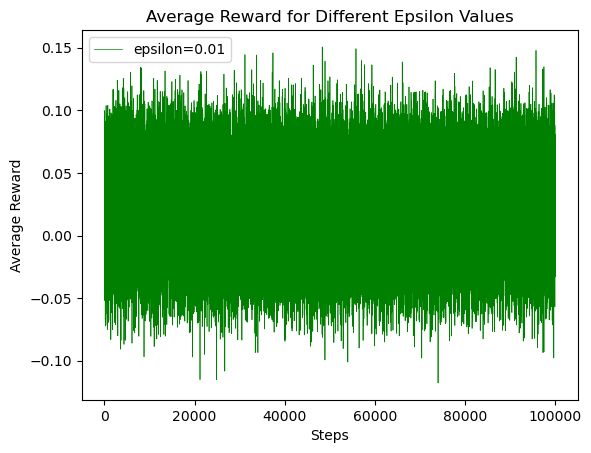

In [46]:
import matplotlib.pyplot as plt
# Define colors for each epsilon value
colors = ['green', 'red', 'blue']

# Plot average reward for each epsilon
plt.plot(agent.get_average_rewards(), label=f'epsilon=0.01', color='green', linewidth=0.5)
    
# plt.text(0, 1.4, f'$\epsilon$={0.1}', 
#          color='blue', fontsize=10, verticalalignment='center')

# plt.text(800, 1.2, f'$\epsilon$={0.01}', 
#          color='red', fontsize=10, verticalalignment='center')

# plt.text(500, 0.92, f'$\epsilon$={0} (greedy)', 
#          color='green', fontsize=10, verticalalignment='center')


# Add labels and title
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.title('Average Reward for Different Epsilon Values')
plt.legend()

In [11]:
# Create a 2D array
arr = np.array([[10, 20, 30],
                [40, 50, 60]])

# Indices of the elements to take from each row
indices = np.array([0, 2])

# Take one element from each row using the specified indices
result = np.take_along_axis(arr, indices[:, None], axis=1).flatten()

print(result)

[10 60]


In [35]:
indices[:, None]

array([[0],
       [2]])

In [36]:
np.argmax(arr, axis=0)

array([1, 1, 1])

In [37]:
np.argmax(arr, axis=1)

array([2, 2])

In [43]:
np.random.binomial(1, 0.1, 10)

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [42]:
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
coin = np.array([0, 1, 0])

np.where(coin, a, b)

array([4, 2, 6])

In [12]:
indices = np.array([1, 0])
arr[np.arange(arr.shape[0]), indices] += 1


In [13]:
arr

array([[10, 21, 30],
       [41, 50, 60]])